In [49]:
# importando as bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.utils import shuffle

In [50]:
# carregando os dados
data = pd.read_csv("/datasets/Churn.csv")

In [51]:
# visualizando os dados
data.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4852,4853,15574137,Ch'in,687,Spain,Male,35,3.0,0.00,2,1,1,176450.19,0
8680,8681,15782939,Storey,747,France,Male,42,4.0,80214.36,1,1,0,115241.96,1
617,618,15766575,Larionova,612,Germany,Female,62,8.0,140745.33,1,1,0,193437.89,1
5482,5483,15642619,Mayne,603,Spain,Male,46,2.0,0.00,2,1,0,174478.54,0
8907,8908,15710671,Gordon,786,France,Male,34,3.0,137361.96,1,0,0,183682.09,0
4443,4444,15566467,Hannah,683,Germany,Female,32,0.0,138171.10,2,1,1,188203.58,0
1308,1309,15662294,Bennett,710,France,Male,33,10.0,118327.17,2,1,1,192928.82,0
7414,7415,15802869,Ball,737,Germany,Female,45,2.0,99169.67,2,1,1,78650.95,0
5492,5493,15568487,Gorshkov,712,France,Male,35,7.0,124616.23,1,1,1,69320.97,0
4345,4346,15584536,Barber,720,Germany,Male,46,3.0,97042.60,1,1,1,133516.51,1


In [52]:
# visualizando os tipos de dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Conclusions:

- Data types are okay.
- We need to handle missing data and NaN values in the Tenure column.
- The Tenure field could be converted to an integer; however, it doesn't seem necessary at this point.
- We will change the headers to lowercase.
- We are dealing with a classification problem (Exited or Churned Y/N), so we will use Decision Tree, Random Forest, and Logistic Regression models, then decide which has the best F1-score.
- We need to encode categorical features like Gender and Geography. We will not process Surname as we assume that the surname does not affect churn.
- We need to scale the features because they have very different scales (e.g., age and account balance).
- We need to evaluate class balance and apply over or under-sampling if necessary.

In [53]:
# mudando headers para lowercase
data.columns = data.columns.str.lower()

In [54]:
# substituindo valores vazios em tenure por 0, pois não podemos usar algo como "unknown" para escalar as características mais adiante
data["tenure"] = data["tenure"].fillna(0)
data["tenure"].value_counts()

0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: tenure, dtype: int64

In [55]:
# checando valores vazios
nan_columns = data.columns[data.isnull().any()].tolist()
print(nan_columns)

[]


In [56]:
# preparando os dados
# removendo a coluna surname para que não atrapalhe a codificação one hot a ser feita em gender e geography
data_noname = data.drop("surname", axis=1)

In [57]:
# preparando os dados
# realizando codificação one hot em gender e removendo a primeira coluna, pois sua alta correlação vai confundir o modelo

data_ohe = pd.get_dummies(data_noname,columns=["gender"],drop_first=True)
data_ohe.sample(10)

,rownumber,customerid,creditscore,geography,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,gender_Male
1196,1197,15739131,718,Germany,28,0.0,65643.30,1,1,0,28760.99,0,1
2411,2412,15739502,549,Germany,31,9.0,135020.21,2,1,1,23343.18,0,0
9291,9292,15679804,636,France,36,5.0,117559.05,2,1,1,111573.30,0,1
4130,4131,15731669,554,France,39,2.0,129709.62,1,1,0,173197.12,0,1
6424,6425,15782608,743,France,43,0.0,0.00,2,0,0,113079.19,1,1
3175,3176,15764604,586,France,35,7.0,164769.02,3,1,0,119814.25,1,0
3109,3110,15735878,850,Germany,47,10.0,134381.52,1,0,0,26812.89,1,0
4500,4501,15697318,771,Germany,32,9.0,77487.20,1,0,0,33143.04,0,1
6229,6230,15669741,777,France,36,7.0,0.00,1,1,0,106472.34,0,1
6913,6914,15784180,564,France,36,7.0,206329.65,1,1,1,46632.87,1,0


In [58]:
# preparando os dados
# realizando codificação de rótulos em geography sem ordenamento, pois países não seguem uma ordem em particular
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data_ohe["geography"] = encoder.fit_transform(data_ohe["geography"])
data_ohe = data_ohe.rename(columns={"gender_Male":"gender_male"})
data_ohe.sample(10)

,rownumber,customerid,creditscore,geography,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,gender_male
8266,8267,15706764,560,0,35,1.0,0.00,2,1,0,3701.63,0,0
1425,1426,15583668,726,0,42,2.0,109471.79,1,0,1,175161.05,0,0
7767,7768,15748660,561,1,49,0.0,102025.32,1,1,0,133051.64,1,0
9694,9695,15659710,581,0,25,5.0,77886.53,2,1,0,150319.49,0,1
8944,8945,15752312,551,2,49,1.0,150777.72,2,1,1,135757.27,0,1
8455,8456,15692207,609,0,53,0.0,0.00,2,1,1,124218.27,0,0
2262,2263,15586264,572,0,43,0.0,140431.98,1,1,0,26450.57,1,1
1551,1552,15749177,730,2,52,7.0,0.00,2,0,1,122398.84,0,0
7880,7881,15612418,744,0,38,9.0,0.00,2,0,0,20940.76,0,0
2515,2516,15744327,564,0,40,4.0,0.00,1,1,0,85455.62,1,1


In [59]:
# preparando os dados para treinamento, separando caracteristicas de objetivo
# removendo das caracteristicas o rownumber a customerid pois não sao realmente caracteristicas, apenas identificadores
target = data_ohe["exited"]
features = data_ohe.drop(["exited","customerid","rownumber"],axis=1)

In [60]:
# separando em um conjunto de treinamento e outro de teste

features_train, features_valid, target_train, target_valid = train_test_split(features,target, test_size=.25, random_state=12345)

In [61]:
# escalando as características
from sklearn.preprocessing import StandardScaler

numeric = ['creditscore','age','tenure','balance','numofproducts','estimatedsalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

/tmp/ipykernel_103/439256887.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_103/439256887.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [62]:
# treinando modelos sem considerar o balanceamento - Arvore de Decisão

# instanciando o modelo
treemodel = DecisionTreeClassifier(random_state=12345, max_depth=10)

# treinando o modelo
treemodel.fit(features_train,target_train)

# testando previsões conjunto de validação
tree_prediction_valid = treemodel.predict(features_valid)

# calculando f1 score
f1tree = f1_score(target_valid,tree_prediction_valid)
print(f1tree)

0.5337915234822451


In [63]:
# treinando modelos sem considerar o balanceamento - Floresta Aleatória

# Instanciando o modelo
rfmodel = RandomForestClassifier(random_state=12345, n_estimators=50)

# treinando o modelo
rfmodel.fit(features_train,target_train)

# testando previsões conjunto de validação
rf_prediction_valid = rfmodel.predict(features_valid)

# calculando f1 score
f1forest = f1_score(target_valid,rf_prediction_valid)
print(f1forest)

0.5611510791366907


In [64]:
# treinando modelos sem considerar o balanceamento - Regressão logística

# Instanciando o modelo
lrmodel = LogisticRegression(random_state=12345, solver='liblinear')

# treinando o modelo
lrmodel.fit(features_train,target_train)

# testando previsões conjunto de validação
lr_prediction_valid = lrmodel.predict(features_valid)

# calculando f1 score
f1lr = f1_score(target_valid,lr_prediction_valid)
print(f1lr)

0.2647058823529412


Conclusion - Training the models without balancing yields results that are only slightly better than a random model with a 50% chance of being correct. We obtained an F1-score of 0.53 for the Decision Tree, 0.56 for the Random Forest, and 0.26 for Logistic Regression.

0    0.7963
1    0.2037
Name: exited, dtype: float64


<AxesSubplot:>

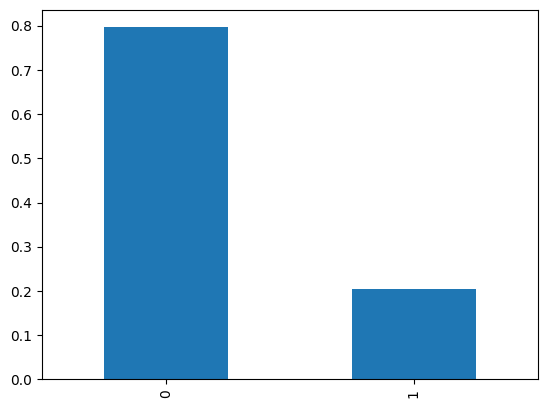

In [66]:
# analisando o balanceamento / frequências de classe

class_frequency = data_ohe["exited"].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(
    kind="bar"
)

Conclusion - we have many more customers that are not churved (exited = 0). We need to class balancing

In [67]:
# comparando os modelos desbalanceados com um modelo constante de valor 0 (exited = 0)

target_pred_constant = pd.Series(0,index=target.index)
print(accuracy_score(target,target_pred_constant))

0.7963


Conclusion - Our unbalanced models perform poorly because if we predicted 0 for every observation, we would have an accuracy of 80%, which is much higher than our models. This result indicates that the models are not capturing significant patterns in the data.

In [68]:
# criando uma matriz de confusão avaliando as métricas - Arvore de decisão

print(confusion_matrix(target_valid,tree_prediction_valid))
print("Sensibilidade:", recall_score(target_valid,tree_prediction_valid))
print("Precisão:",precision_score(target_valid,tree_prediction_valid))
print("f1:", f1_score(target_valid,tree_prediction_valid))

[[1860  105]
 [ 302  233]]
Sensibilidade: 0.4355140186915888
Precisão: 0.6893491124260355
f1: 0.5337915234822451


Conclusion: The unbalanced Decision Tree model has a precision of 0.69 but a recall of 0.44, resulting in an F1-score of 0.53. The model has a high number of false negatives (302) and false positives (102).

In [69]:
# criando uma matriz de confusão avaliando as métricas - Floresta Aleatória

print(confusion_matrix(target_valid,rf_prediction_valid))
print("Sensibilidade:", recall_score(target_valid,rf_prediction_valid))
print("Precisão:",precision_score(target_valid,rf_prediction_valid))
print("f1:", f1_score(target_valid,rf_prediction_valid))

[[1900   65]
 [ 301  234]]
Sensibilidade: 0.4373831775700935
Precisão: 0.782608695652174
f1: 0.5611510791366907



Conclusion: The unbalanced Random Forest model has a precision of 0.78 but a recall of 0.44, resulting in an F1-score of 0.56. The model has a high number of false negatives (301) and false positives (65).

In [70]:
# criando uma matriz de confusão avaliando as métricas - Regressão Logística

print(confusion_matrix(target_valid,lr_prediction_valid))
print("Sensibilidade:", recall_score(target_valid,lr_prediction_valid))
print("Precisão:",precision_score(target_valid,lr_prediction_valid))
print("f1:", f1_score(target_valid,lr_prediction_valid))

[[1910   55]
 [ 445   90]]
Sensibilidade: 0.16822429906542055
Precisão: 0.6206896551724138
f1: 0.2647058823529412


Conclusion: The unbalanced Logistic Regression model has a precision of 0.62 but a recall of 0.17, resulting in an F1-score of 0.26. The model has a high number of false negatives (445) and false positives (55).

In [71]:
# realizando superamostragem de exited=1 pois temos poucas observações destes casos

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
   
    features_train_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_train_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_train_upsampled, target_train_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_train_upsampled, target_train_upsampled
    
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 10)

print(features_train_upsampled.shape)
print(target_train_upsampled.shape)

(21018, 10)
(21018,)


In [72]:
# rodando modelo de árvore, agora com superamostragem e balanceamento

# instanciando o modelo
treemodel = DecisionTreeClassifier(random_state=12345, max_depth=10, class_weight='balanced')

# treinando o modelo
treemodel.fit(features_train_upsampled,target_train_upsampled)

# testando previsões conjunto de validação
tree_prediction_valid = treemodel.predict(features_valid)

# calculando f1 score
f1tree = f1_score(target_valid,tree_prediction_valid)
print(f1tree)

0.547112462006079


In [73]:
# rodando modelo de floresta, agora com superamostragem e balanceamento

# Instanciando o modelo
rfmodel = RandomForestClassifier(random_state=12345, n_estimators=50, class_weight="balanced")

# treinando o modelo
rfmodel.fit(features_train_upsampled,target_train_upsampled)

# testando previsões conjunto de validação
rf_prediction_valid = rfmodel.predict(features_valid)

# calculando f1 score
f1forest = f1_score(target_valid,rf_prediction_valid)
print(f1forest)

0.5985699693564862


In [74]:
# rodando modelo de regressão logística, agora com superamostragem e balanceamento

# Instanciando o modelo
lrmodel = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

# treinando o modelo
lrmodel.fit(features_train_upsampled,target_train_upsampled)

# testando previsões conjunto de validação
lr_prediction_valid = lrmodel.predict(features_valid)

# calculando f1 score
f1lr = f1_score(target_valid,lr_prediction_valid)
print(f1lr)

0.4853723404255319



Conclusion: Balancing and oversampling improved the F1-score for all models

In [75]:
# otimizando hiperparâmetros do modelo de árvore

# importando gridsearch
from sklearn.model_selection import GridSearchCV

# Definindo os hiperparametros
param_grid = {
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,5,7,10,15],
    'class_weight':["balanced"]
}

# Instanciando o modelo
dtc = DecisionTreeClassifier()

# instanciando o GridSearchCV
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5, scoring='f1')

# Fazendo o fit
grid_search.fit(features_train_upsampled, target_train_upsampled)

# coletando resultados
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Score:  0.9613754923421312


In [76]:
# rodando modelo de árvore, agora com superamostragem e balanceamento e hiperparâmetros otimizados

# instanciando o modelo
treemodel = DecisionTreeClassifier(random_state=12345, criterion="gini",max_depth=15, min_samples_leaf=1, min_samples_split=5, class_weight='balanced')

# treinando o modelo
treemodel.fit(features_train_upsampled,target_train_upsampled)

# testando previsões conjunto de validação
tree_prediction_valid = treemodel.predict(features_valid)

# calculando f1 score
f1tree = f1_score(target_valid,tree_prediction_valid)
print(f1tree)

0.5137777777777779


In [77]:
# otimizando hiperparâmetros do modelo de floresta

# Definindo os hiperparametros
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'n_estimators':[50, 60, 70, 80, 100],
    'max_depth':[2,5,7,10,15],
    'class_weight':["balanced"]
}

# Instanciando o modelo
rfc = RandomForestClassifier()

# instanciando o GridSearchCV
rfcgrid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='f1')

# treinando o modelo
rfcgrid_search.fit(features_train_upsampled, target_train_upsampled)

# coletando resultados
print("Best Parameters: ", rfcgrid_search.best_params_)
print("Best Score: ", rfcgrid_search.best_score_)

Best Parameters:  {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score:  0.9794275006890614


In [78]:
# rodando modelo de floresta, agora com superamostragem e balanceamento e hiperparametros otimizados

# Instanciando o modelo
rfmodel = RandomForestClassifier(random_state=12345, n_estimators=100, class_weight="balanced", max_depth=15, max_features="log2",min_samples_leaf=1, min_samples_split=5)

# treinando o modelo
rfmodel.fit(features_train_upsampled,target_train_upsampled)

# testando previsões conjunto de validação
rf_prediction_valid = rfmodel.predict(features_valid)

# calculando f1 score
f1forest = f1_score(target_valid,rf_prediction_valid)
print(f1forest)

0.6089494163424125


In [79]:
# otimizando hiperparâmetros do modelo de regressão

# Definindo os hiperparametros
param_grid = {
    'C': [0.1, 1, 5, 10],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 500, 1000],
    'solver':['liblinear','saga'],
    'class_weight':['balanced']
}

# Instanciando o modelo
lr = LogisticRegression()

# instanciando o GridSearchCV
lrgrid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='f1')

# treinando o modelo
lrgrid_search.fit(features_train_upsampled, target_train_upsampled)

# coletando resultados
print("Best Parameters: ", lrgrid_search.best_params_)
print("Best Score: ", lrgrid_search.best_score_)

Best Parameters:  {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Best Score:  0.758086619077775


In [84]:
# rodando modelo de regressão logística, agora com superamostragem e balanceamento e hiperparametros otimizados

# Instanciando o modelo
lrmodel = LogisticRegression(random_state=12345, solver='saga', class_weight='balanced', C=0.1, max_iter=100, penalty='l1')

# treinando o modelo
lrmodel.fit(features_train_upsampled,target_train_upsampled)

# testando previsões conjunto de validação
lr_prediction_valid = lrmodel.predict(features_valid)

# calculando f1 score
f1lr = f1_score(target_valid,lr_prediction_valid)
print(f1lr)

0.4873837981407703


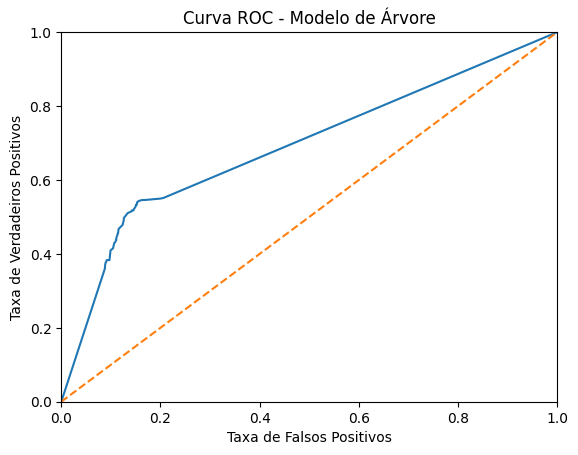

AUC-ROC Árvore: 0.6909395733751873


In [85]:
# curva ROC e AUC-ROC score

# modelo de árvore

probabilities_valid = treemodel.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid,probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Modelo de Árvore')
plt.show()

auc_roc = roc_auc_score(target_valid,probabilities_one_valid)

print("AUC-ROC Árvore:",auc_roc)

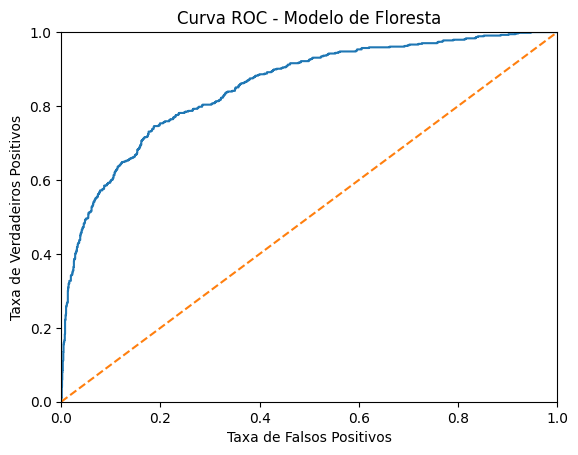

AUC_ROC Floresta: 0.8520701053482675


In [86]:
# curva ROC e AUC-ROC score

# modelo de floresta

probabilities_valid = rfmodel.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid,probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Modelo de Floresta')
plt.show()

auc_roc = roc_auc_score(target_valid,probabilities_one_valid)

print("AUC_ROC Floresta:",auc_roc)

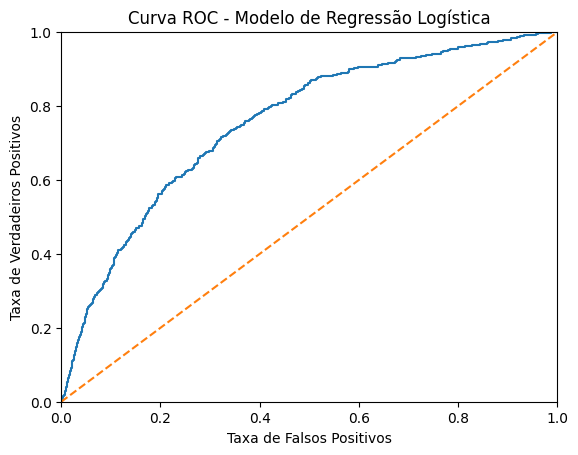

AUC_ROC Regressão Logística: 0.7549185512829658


In [87]:
# curva ROC e AUC-ROC score

# modelo de regressão logística

probabilities_valid = lrmodel.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid,probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Modelo de Regressão Logística')
plt.show()

auc_roc = roc_auc_score(target_valid,probabilities_one_valid)

print("AUC_ROC Regressão Logística:",auc_roc)

Conclusions:
- The balanced Random Forest model, with oversampling and optimized hyperparameters, achieved an F1-score of 0.61.
- Since the F1-scores on the training set are considerably higher than on the test set, we can infer that the model is overfitting.
- Interestingly, for the Decision Tree model, after balancing, oversampling, and hyperparameter tuning, the F1-score actually decreased.